In [6]:
import tensorflow as tf
print(tf.__version__)

2.14.0


<h3>Read Text</h3>

In [7]:
# Open file
with open(r'../Dataset/poem.txt', 'r') as file:
    data = file.read()

# Lowercase and save as list
corpus = data.lower().split("\n")

# Corpus length
print("Corpus len = ", len(corpus))

print("")

print("5 rows in corpus : ")
for i in range(5):
    print(corpus[i])


Corpus len =  4557

5 rows in corpus : 
looking for some education
made my way into the night
all that bullshit conversation
baby, cannot you read the signs? i will not bore you with the details, baby
i do not even wanna waste your time


<h3>Tokenize Corpus</h3>

In [8]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')

tokenizer.fit_on_texts(corpus)

In [9]:
tokenizer.texts_to_sequences([corpus[1]])[0]

[118, 7, 119, 191, 4, 121]

<h3>Sequence n-gram

In [10]:
def n_gram_seqs(corpus, tokenizer):
    input_sequences = []

    for line in corpus:
      token_list = tokenizer.texts_to_sequences([line])[0]

      for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]

        input_sequences.append(n_gram_sequence)

    return input_sequences

Example of sequence n-gram

In [11]:
example_n_gram = n_gram_seqs([corpus[1]], tokenizer)

print("n_gram sequences:\n")
example_n_gram

n_gram sequences:



[[118, 7],
 [118, 7, 119],
 [118, 7, 119, 191],
 [118, 7, 119, 191, 4],
 [118, 7, 119, 191, 4, 121]]

Apply sequence n_gram to whole corpus

In [14]:
corpus_n_gram = n_gram_seqs(corpus, tokenizer)

# Save max length
max_corpus_n_gram = max([len(x) for x in corpus])

print(f"n_grams of corpus_n_gram have length: {len(corpus_n_gram)}")
print(f"maximum length of sequences is: {max_corpus_n_gram}")

n_grams of corpus_n_gram have length: 33048
maximum length of sequences is: 130


<h3>Padding sequence

In [15]:
def pads_sequences(input_sequences, maxlen):
    pads = tf.keras.preprocessing.sequence.pad_sequences(input_sequences, maxlen=maxlen, padding="pre")

    return pads

Example of padding sequence

In [16]:
example_pads = pads_sequences(example_n_gram, max([len(x) for x in example_n_gram]))
example_pads

array([[  0,   0,   0,   0, 118,   7],
       [  0,   0,   0, 118,   7, 119],
       [  0,   0, 118,   7, 119, 191],
       [  0, 118,   7, 119, 191,   4],
       [118,   7, 119, 191,   4, 121]])

Applying padding sequence to whole corpus

In [17]:
corpus_padding = pads_sequences(corpus_n_gram, max_corpus_n_gram)
print(f"padded corpus has shape: {corpus_padding.shape}")

padded corpus has shape: (33048, 130)


<h3>Split data to feature and label

In [18]:
total_words = len(tokenizer.word_index) + 1

print(total_words)

3855


In [19]:
def split(input_sequences, total_words):
    features = input_sequences[:, :-1]
    labels = input_sequences[:, -1]
    one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

    return features, one_hot_labels

In [20]:
feature_example, label_example = split(example_pads, total_words)

print(f"labels have shape: {label_example.shape}")
print("\nnew features after label removed:\n")
feature_example

labels have shape: (5, 3855)

new features after label removed:



array([[  0,   0,   0,   0, 118],
       [  0,   0,   0, 118,   7],
       [  0,   0, 118,   7, 119],
       [  0, 118,   7, 119, 191],
       [118,   7, 119, 191,   4]])

In [21]:
# Split the whole corpus
features, labels = split(corpus_padding, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (33048, 129)
labels have shape: (33048, 3855)


<h3>Create model

In [22]:
def create_model(total_words, max_corpus_n_gram):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(total_words, 100, input_length=max_corpus_n_gram-1),
        # tf.keras.layers.GlobalAveragePooling1D(),
        # tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64)),
        # tf.keras.layers.LSTM(units=64, activation='relu'),
        # tf.keras.layers.Dense(units=64, activation='relu'),
        tf.keras.layers.Dense(units=total_words, activation='softmax')
    ])

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])
    
    return model

Model summary

In [23]:
model = create_model(total_words, max_corpus_n_gram)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 129, 100)          385500    
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dense (Dense)               (None, 3855)              497295    
                                                                 
Total params: 967275 (3.69 MB)
Trainable params: 967275 (3.69 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Train model

In [24]:
history = model.fit(features, labels, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
1033/1033 [==============================] - 102s 96ms/step - loss: 6.4035 - accuracy: 0.0385
Epoch 2/100
1033/1033 [==============================] - 112s 109ms/step - loss: 5.8599 - accuracy: 0.0657
Epoch 3/100
1033/1033 [==============================] - 111s 108ms/step - loss: 5.4634 - accuracy: 0.1008
Epoch 4/100
1033/1033 [==============================] - 113s 109ms/step - loss: 5.1266 - accuracy: 0.1345
Epoch 5/100
1033/1033 [==============================] - 111s 108ms/step - loss: 4.8415 - accuracy: 0.1629
Epoch 6/100
1033/1033 [==============================] - 112s 108ms/step - loss: 4.5951 - accuracy: 0.1852
Epoch 7/100
1033/1033 [==============================] - 113s 110ms/step - loss: 4.3718 - accuracy: 0.2109
Epoch 8/100
1033/1033 [==============================] - 113s 109ms/step - loss: 4.1644 - accuracy: 0.2347
Epoch 9/100
1033/1033 [==============================] - 114s 111ms/step - loss: 3.9722 - accuracy: 0.2560
Epoch 10/100
1033/1033 [==============

<h3>Plot Grafik</h3>

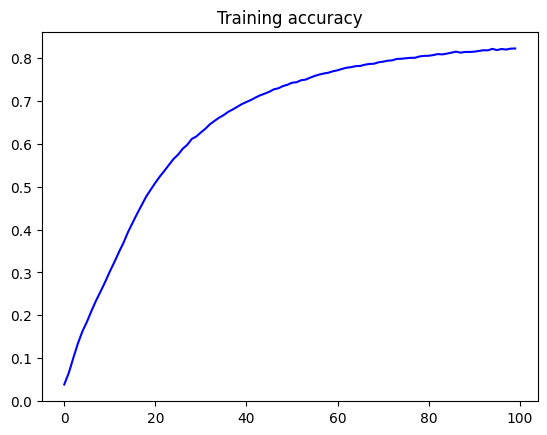

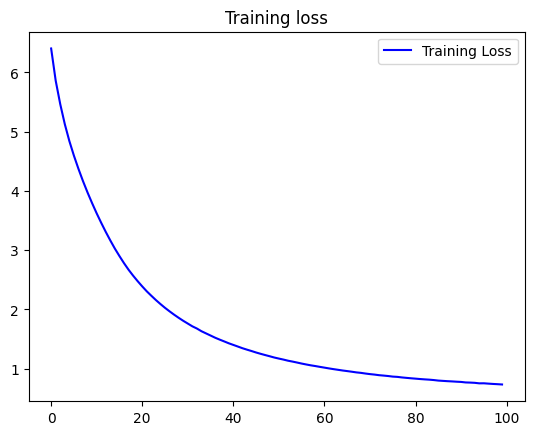

In [25]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

<h3>Test</h3>

In [26]:
import numpy as np

seed_text = "i love you"
next_words = 30

for _ in range(next_words):
    
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    
    token_list = pads_sequences([token_list], maxlen=max_corpus_n_gram-1)
    
    predicted = model.predict(token_list, verbose=0)
    
    predicted = np.argmax(predicted, axis=-1).item()
    
    output_word = tokenizer.index_word[predicted]
    
    seed_text += " " + output_word

print(seed_text)

i love you to be reminded you are time out of you found my friend came woah you take my head your body being told me umm you walk thee do not see


<h3>Save Model</h3>

In [28]:
model.save('model_emotion.h5')

<h3>Save tokenizer pkl

In [29]:
import pickle

with open('tokenizer_emotion.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

print("Tokenizer berhasil disimpan ke dalam tokenizer.pkl")

Tokenizer berhasil disimpan ke dalam tokenizer.pkl
